According to Cullan's [notes on zero-pointing](https://www.overleaf.com/read/mtrzpqmsctcv#7117e3), an incorrect value of $H_0$ results in a vertical shift in $\eta$ v. $z$ (or $V_{\rm pec}$ v. $z$).  However, when I accidentally calculated $V_{\rm pec}$ for the EDR TF sample with $h \neq 1$ (using Watkins+15 estimator), I found that it removed the correlation between $V_{\rm pec}$ and $z_{\rm CMB}$.  Is this real?

In [9]:
import numpy as np

from scipy.stats import binned_statistic

from astropy import cosmology
from astropy.table import Table
import astropy.constants as const
import astropy.units as u

import matplotlib.pyplot as plt

# Import Y1 data

The TF distance modulus calculated in this file is independent of the calibrated $H_0$.

In [2]:
filename = 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits'

galaxies = Table.read(filename)
galaxies[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,mag,,,,,,,,,mag,mag
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876

# Define functions to calculate $V_{\rm pec}$, $\eta$

The functions for $V_{\rm pec}$ are copied from `pv_calc.py` (can't import them directly) and are for the Watkins15+ estimator.

The functions for $\eta$ are based on code in `TF_iron_jointTFR-varyV0-perpdwarf.ipynb`

In [4]:
def zmod(z, Om, Ol, j0=1):
    '''
    Compute the modified redshift, which accounts for non-linearity in the 
    Hubble expansion
    
    Default values: j0 = 1 (LCDM jerk)
    '''
    q0 = 0.5*(Om - 2*Ol) # deceleration parameter
    
    return z*(1 + 0.5*(1 - q0)*z - (1./6.)*(1 - q0 - 3*q0**2 + j0)*z**2)


def vpec(z_mod, mu, c=3e5, H0=100):
    '''
    Compute the peculiar velocity based on the approximation described by 
    Watkins+ (2015)
    
    Default values: c = 3x10^5 km/s, H0 = 100 km/s/Mpc
    '''
    return (c*z_mod/(1 + z_mod))*(np.log(c*z_mod/(1e-5 * H0)) - 0.2*mu*np.log(10))

In [5]:
def mu_z(z, H0=100, Om0=0.3151):
    '''
    Compute the distance modulus based on the observed redshift, assuming flat 
    LCDM.

    Default values: H0 = 100 km/s/Mpc, Om0 = 0.3151
    '''
    cosmo = cosmology.FlatLambdaCDM(H0=H0*u.km/(u.s*u.Mpc), Om0=Om0)
    mu_z = cosmo.distmod(z)
    return mu_z.value

# Compute $V_{\rm pec}$ for a range of $H_0$ values

In [7]:
h = np.arange(0.6, 1.05, 0.05)
H0 = 100*h*u.km/u.s/u.Mpc

Om = 0.3151 # DESI fiducial cosmology

c = const.c.to('km/s')

In [28]:
z_mod = zmod(galaxies['Z_DESI_CMB'], Om, 1-Om) # Assuming flat LCDM

In [29]:
PV = np.zeros((len(h), len(galaxies)))
PV_err = np.zeros((len(h), len(galaxies)))

rng = np.random.default_rng()
N_samples = 10000

for i in range(len(h)):
    PV[i] = vpec(z_mod, galaxies['MU_TF'], c.value, H0[i].value)

    for j in range(len(galaxies)):
        z_desi_random = rng.normal(galaxies['Z_DESI_CMB'][j], 
                                   galaxies['ZERR_DESI'][j], 
                                   size=N_samples)
        mu_random = rng.normal(galaxies['MU_TF'][j], 
                               galaxies['MU_TF_ERR'][j], 
                               size=N_samples)
        zmod_random = zmod(z_desi_random[z_desi_random>0], Om, 1-Om)
        PV_random = vpec(zmod_random, 
                         mu_random[z_desi_random>0], 
                         c.value, 
                         H0[i].value)

        PV_err[i,j] = np.nanstd(PV_random)

/tmp/ipykernel_1412875/3360724955.py:20: RuntimeWarning: invalid value encountered in log
  return (c*z_mod/(1 + z_mod))*(np.log(c*z_mod/(1e-5 * H0)) - 0.2*mu*np.log(10))
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plot the results

In [12]:
def profile_histogram(x, y, xbins, yerr=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.

    Note: Function copied from TF_PV_corr_checks.ipynb
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Use uncertainties to weight the summary statistics.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if yerr is None:
            raise ValueError('need to define yerr if using weighted fit.')
            
        w = 1/yerr**2
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

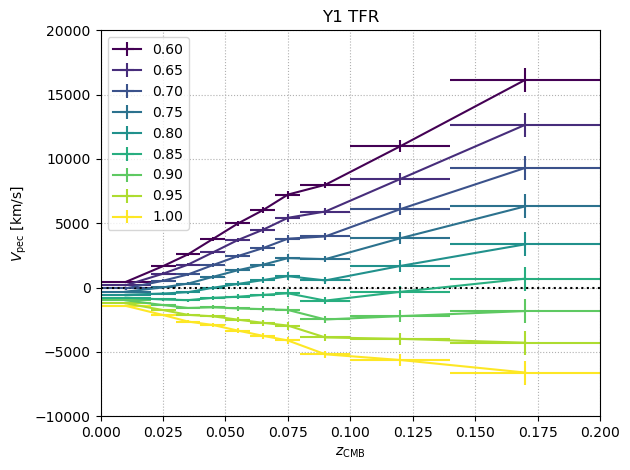

In [39]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])


plt.figure(tight_layout=True)

cm = plt.get_cmap('viridis')
colors = cm(np.linspace(0,1,len(h)))

for i in range(len(h)):
    N, PV_avg, PV_std = profile_histogram(galaxies['Z_DESI_CMB'], PV[i], zbins, PV_err[i], median=True)
    plt.errorbar(zc, PV_avg, xerr=dz, yerr=PV_std, label=f'{h[i]:.2f}', c=colors[i])

plt.hlines(0, 0, 0.2, colors='k', linestyles='dotted')

plt.grid(linestyle=':')

plt.legend()
plt.xlim((0, 0.2))
plt.ylim((-10000, 20000))
plt.xlabel(r'$z_{\rm CMB}$')
plt.ylabel(r'$V_{\rm pec}$ [km/s]')
plt.title('Y1 TFR');

# Compute $\eta$ for a range of $H_0$ values

In [10]:
logdist = np.zeros((len(h), len(galaxies)))
logdist_err = np.zeros((len(h), len(galaxies)))

rng = np.random.default_rng()
N_samples = 10000

for i in range(len(h)):
    
    muz = mu_z(galaxies['Z_DESI_CMB'], H0=H0[i].value)
    
    logdist[i] = 0.2*(muz - galaxies['MU_TF'])

    for j in range(len(galaxies)):
        z_desi_random = rng.normal(galaxies['Z_DESI_CMB'][j], 
                                   galaxies['ZERR_DESI'][j], 
                                   size=N_samples)
        muz_random = mu_z(z_desi_random, H0=H0[i].value)

        logdist_err[i,j] = np.nanstd(0.2*(muz_random - galaxies['MU_TF'][j]))

## Plot the results

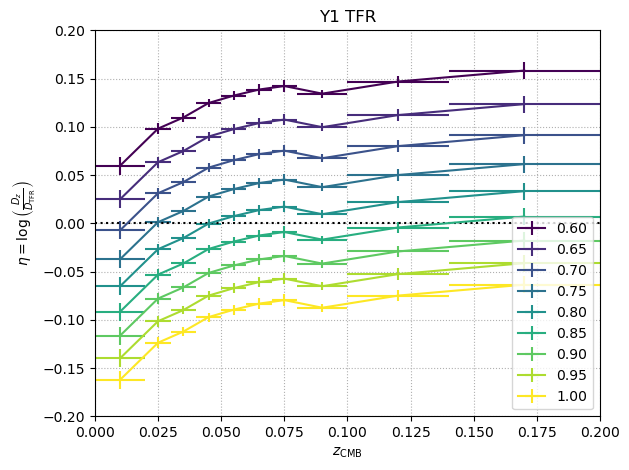

In [15]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])


plt.figure(tight_layout=True)

cm = plt.get_cmap('viridis')
colors = cm(np.linspace(0,1,len(h)))

for i in range(len(h)):
    N, logdist_avg, logdist_std = profile_histogram(galaxies['Z_DESI_CMB'], logdist[i], zbins, logdist_err[i], median=True)
    plt.errorbar(zc, logdist_avg, xerr=dz, yerr=logdist_std, label=f'{h[i]:.2f}', c=colors[i])

plt.hlines(0, 0, 0.2, colors='k', linestyles='dotted')

plt.grid(linestyle=':')

plt.legend()
plt.xlim((0, 0.2))
plt.ylim((-0.2, 0.2))
plt.xlabel(r'$z_{\rm CMB}$')
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\rm TFR}} \right)$')
plt.title('Y1 TFR');